# Outlier Detection with Autoencoders

In [1]:
import os
from datetime import datetime
import itertools
import random
from typing import Dict, List, Tuple, Type
import warnings

from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, Markdown

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms

C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\marti\Anaconda3\envs\bakalarka\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Creating and Preprocessing the Data

### Loading the data

In [2]:
cardio_dict = scipy.io.loadmat('cardio.mat')

In [3]:
cardio_dict

{'__header__': b'MATLAB 5.0 MAT-file, written by Octave 3.8.0, 2014-12-18 10:48:09 UTC',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[ 0.00491231,  0.69319077, -0.20364049, ...,  0.23149795,
         -0.28978574, -0.49329397],
        [ 0.11072935, -0.07990259, -0.20364049, ...,  0.09356344,
         -0.25638541, -0.49329397],
        [ 0.21654639, -0.27244466, -0.20364049, ...,  0.02459619,
         -0.25638541,  1.14001753],
        ...,
        [-0.41835583, -0.91998844, -0.16463485, ..., -1.49268341,
          0.24461959, -0.49329397],
        [-0.41835583, -0.91998844, -0.15093411, ..., -1.42371616,
          0.14441859, -0.49329397],
        [-0.41835583, -0.91998844, -0.20364049, ..., -1.28578165,
          3.58465295, -0.49329397]]),
 'y': array([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])}

In [4]:
X = cardio_dict['X']
y = cardio_dict['y'].flatten()

In [5]:
INPUT_SIZE = X.shape[1]
print(f'Size of input example: {INPUT_SIZE}')

Size of input example: 21


### Data splitting

Divide the dataset into inliers and outliers:
- only inliers are used for trainig the autoencoders
- outliers are then mixed with the test set

In [6]:
X_inliers = X[y==0]
y_inliers = np.zeros(len(X_inliers), dtype=int)
X_outliers = X[y==1]
y_outliers = np.ones(len(X_outliers), dtype=int)
print(f'Number of inliers: {len(y_inliers)}, Number of outliers: {len(y_outliers)}')

Number of inliers: 1655, Number of outliers: 176


Split the inliers into training, validation, and testing set:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_inliers, y_inliers, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1) # 0.2 x 0.8 = 0.16

Add outliers only to the test set

In [8]:
X_test = np.concatenate((X_test, X_outliers), axis=0)
y_test = np.concatenate((y_test, y_outliers), axis=0)

In [9]:
print(f'Training set: {len(y_train)} examples')
print(f'Validation set: {len(y_val)} examples')
print(f'Testing set: {len(y_test)} examples; inliers: {np.sum(y_test==0)}, outliers: {np.sum(y_test==1)}')

Training set: 1059 examples
Validation set: 265 examples
Testing set: 507 examples; inliers: 331, outliers: 176


In [10]:
display(X_train.shape)

(1059, 21)

### Creating Dataset and DataLoader instances

In [11]:
class CardioDataset(Dataset):
    def __init__(self, data: np.ndarray, labels: np.ndarray):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.int32]:
        return self.data[idx], self.labels[idx]

In [12]:
train_data = CardioDataset(X_train, y_train)
val_data = CardioDataset(X_val, y_val)

---
---

## Autoencoder Models

### Training functions

In [13]:
def train_one_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss, train_loader: DataLoader):
    '''
    Train one epoch of the model on training dataset batched by the train_loader.
    
    :param nn.Module model: model on which we perform one training epoch
    :param torch.optim.Optimizer optimizer: optimizer, e.g. ADAM or SGD
    :param nn.MSELoss criterion: loss function used for training
    :param DataLoader train_loader: data object for batching training set
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs.float(), inputs.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [122]:
def train_model(model: nn.Module, model_name: str, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss,
                train_loader: DataLoader, val_loader: DataLoader, nr_of_epochs: int = 100, verbose: bool = True):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param torch.optim.Optimizer optimizer: optimizer, e.g. ADAM or SGD
    :param nn.MSELoss criterion: loss function used for training
    :param DataLoader train_loader: data object for batching the training set
    :param DataLoader val_loader: data object for batching the validation set
    :param int nr_of_epochs: number of training epochs
    :param bool verbose: determining whether training and validation losses should be printed
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
        model.eval()

        # performance on validation set
        valid_loss = 0.0
        for i, data in enumerate(val_loader):
            inputs, _ = data
            outputs = model(inputs.float())
            loss = criterion(outputs.float(), inputs.float())
            valid_loss += loss.item()
        valid_loss = valid_loss / len(val_loader)

        # logging at each Nth epoch
        if verbose and (epoch + 1) % 20 == 0:
            print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')
        
        # remember model with the best validation loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_model = model.state_dict()
            best_epoch = epoch + 1

    # save the overall best model - if verbose
    if verbose:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        os.makedirs('models/', exist_ok=True)
        model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
        torch.save(best_model, model_path)

### Testing functions

In [51]:
def eval_on_testset(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray, verbose: bool = True) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :param bool verbose: determining whether reconstruction errors should be printed
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.sum((reconstructed_test.detach() - testset_tensor) ** 2, axis=1)
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    if verbose:
        display(error_df[error_df['class'] == 0].describe())
        display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [52]:
def classify_by_error(MSEs: np.ndarray, thres: float) -> np.ndarray:
    '''
    Classify an array of reconstruction errors w.r.t. a threshold
    
    :param np.ndarray MSEs: mean squared reconstruction errors
    :param float thres: threshold of reconstruction error between inliers and outliers
    :returns: binary array of class ids; 0 = inlier, 1 = outlier
    '''
    return np.array(MSEs > thres, dtype=int)

In [53]:
def plot_confusion_matrix(confusion_mat: np.ndarray):
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray confusion_mat: confusion matrix between true and predicted labels
    '''
    class_labels = ['Inlier', 'Outlier']
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, fmt="d", annot_kws={"size": 14});
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

In [54]:
def try_threshold_grid(MSEs: np.ndarray, true_labels: np.ndarray, model_name: str, start: float = 0.0,
                       stop: float = 5.0, num_thresholds: int = 10, verbose_lvl: int = 2) -> Tuple[float, float]:
    '''
    Plot a confusion matrix of true vs predicted labels.
    
    :param np.ndarray MSEs: mean squared reconstruction errors on testing set
    :param np.ndarray true_labels: ground-truth labels
    :param str model_name: model name, e.g. denoising_autoencoder
    :param float start: start of threshold interval
    :param float stop: end of threshold interval
    :param int num_thresholds: number of thresholds tested in the interval
    :param int verbose_lvl: level of verbosity - 0 = no verbosity, 2 = max verbosity
    :returns: threshold with the highest anomaly f1-score, corresponding f1-score
    '''
    best_threshold = None
    best_f1 = 0.0
    if verbose_lvl >= 1:
        display(Markdown(f'#### Model: {model_name}, trying {num_thresholds} thresholds from [{start}, {stop}]'))
    if verbose_lvl == 1:
        display(Markdown('For more detail, call the function with `verbose_lvl=2`'))
        
    for threshold in np.linspace(start, stop, num=num_thresholds):
        predictions = classify_by_error(MSEs, threshold)
        matrix = confusion_matrix(true_labels, predictions)
        class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
        acc_df = pd.DataFrame({
            'Inliers Accuracy': [class_accuracies[0]], 
            'Outliers Accuracy': [class_accuracies[1]], 
            'Overall Accuracy': [accuracy_score(true_labels, predictions)]
        })
        
        outlier_f1 = f1_score(true_labels, predictions)
        if outlier_f1 > best_f1:
            best_f1 = outlier_f1
            best_threshold = threshold
        
        if verbose_lvl >= 2:
            display(Markdown(f'### Threshold {threshold}'))
            display(acc_df.style.hide_index())
            display(Markdown(f'##### Classification Report'))
            print(classification_report(true_labels, predictions))
            # plot_confusion_matrix(matrix)
            display(Markdown('---'))
    
    return best_threshold, best_f1

### Hypeparameter tuning functions

As a general tuning framework, I will try out (in a grid search) the following parameters for each of the architectures:
- Batch size: 32; 64; 128
- Learning rate: 1e-3; 1e-2
- Hidden layer count and dimension: 16; 18; two hidden layers [18, 16]
- Latent space dimension: 10; 12; 14
- 50 thresholds on reconstruction errors from interval [0.1; 5]

#### Setting all random seeds for reproducibility

In [ ]:
def seed_worker(worker_id: int):
    '''
    Set random seed for DataLoader initialization
    
    :param int worker_id: id given by DataLoader
    '''
    worker_seed = 123
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
def seed_all(seed: int = 123):
    '''
    Set random seeds (all of them) for PyTorch training and eval loop
    
    :param int seed: random seed
    '''
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

#### Grid-search functions

In [57]:
def train_eval_test_model(ModelClass: Type[nn.Module], hidden_sizes: List[int], latent_size: int, model_name: str,
                          batch_size: int, learning_rate: float, seed: int) -> Tuple[float, float]:
    '''
    Train and evaluate model with concrete hyperparameters, try threshold grid.
    
    :param Type[nn.Module] ModelClass: class of model to be trained
    :param List[int] hidden_sizes: list determining number of hidden layers and their sizes
    :param int latent_size: size of the latent space
    :param str model_name: name of the model architecture
    :param int batch_size: batch size for training and validation
    :param float learning_rate: learning rate for the optimizer
    :param int seed: random seed for PyTorch
    :returns: best MSE threshold, best F1 score
    '''
    train_loader = DataLoader(train_data, batch_size=batch_size, worker_init_fn=seed_worker, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, worker_init_fn=seed_worker, shuffle=False)
    
    seed_all(seed)
    model = ModelClass(hidden_sizes, latent_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_model(model=model, model_name=model_name, optimizer=optimizer, criterion=criterion,
                train_loader=train_loader, val_loader=val_loader, nr_of_epochs=200, verbose=False)
    
    df, MSEs = eval_on_testset(model, X_test, y_test, verbose=False)
    threshold, f1 = try_threshold_grid(MSEs, y_test, model_name, start=0.1, stop=5.0, num_thresholds=50, verbose_lvl=0)
    return threshold, f1

In [58]:
def grid_search(ModelClass: Type[nn.Module], model_name: str, hidden_sizes_ls: List[List[int]], latent_sizes: List[int],
                batch_sizes: List[int], learning_rates: List[float], seeds: List[int]):
    '''
    Try out grid of hyperparameters constructed as a cartesian product of the given values, 
    return the best parameters according to the model's F1 score.
    
    :param Type[nn.Module] ModelClass: class of model to be trained
    :param str model_name: name of the model architecture
    :param List[List[int]] hidden_sizes_ls: list of lists determining number of hidden layers and their sizes
    :param List[int] latent_sizes: sizes of the latent space
    :param List[int] batch_sizes: batch sizes for training and validation
    :param List[float] learning_rates: learning rates for the optimizer
    :param List[int] seeds: random seeds for PyTorch
    :returns: best hyperparameters, best F1 score
    '''
    best_f1 = 0.0
    best_model_params = None
    
    cartes_product = list(itertools.product(hidden_sizes_ls, latent_sizes, batch_sizes, learning_rates, seeds))
    for hidden_sizes, latent_size, batch_size, learning_rate, seed in tqdm(cartes_product):
        threshold, f1 = train_eval_test_model(ModelClass, hidden_sizes, latent_size, model_name, batch_size, learning_rate, seed)
        if f1 > best_f1:
            best_f1 = f1
            best_model_params = hidden_sizes, latent_size, batch_size, learning_rate, seed, threshold
    return best_model_params, best_f1

---

### 1. Undercomplete AutoEncoder

In [59]:
class UndercompleteAutoEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], latent_size: int):
        super(UndercompleteAutoEncoder, self).__init__()
        
        encode_layers = [nn.Linear(INPUT_SIZE, hidden_sizes[0]), nn.ReLU()]
        for i in range(len(hidden_sizes)-1):
            encode_layers += [nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.ReLU()]
        encode_layers += [nn.Linear(hidden_sizes[-1], latent_size)]
        self.encode = nn.Sequential(*encode_layers)
        
        decode_layers = [nn.Linear(latent_size, hidden_sizes[-1]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            decode_layers += [nn.Linear(hidden_sizes[-i], hidden_sizes[-i-1]), nn.ReLU()]
        decode_layers += [nn.Linear(hidden_sizes[0], INPUT_SIZE)]
        self.decode = nn.Sequential(*decode_layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encode(x)
        x = self.decode(x)
        return x

In [60]:
best_model_params_uae, best_f1_uae = grid_search(ModelClass=UndercompleteAutoEncoder,
                                                 model_name='undercomplete_autoencoder',
                                                 hidden_sizes_ls=[[16], [18], [18, 16]],
                                                 latent_sizes=[12, 14],
                                                 batch_sizes=[32, 64, 128], 
                                                 learning_rates=[1e-3, 1e-2], 
                                                 seeds=[0, 1, 2])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [15:00<00:00,  8.34s/it]


In [61]:
best_params_df_uae = pd.DataFrame([list(best_model_params_uae) + [best_f1_uae]], columns=['Hidden Sizes', 'Latent Size', 'Batch Size', 'Learning Rate', 'Seed', 'Threshold', 'F1 Score'])
display(Markdown('#### Best Parameters'))
display(best_params_df_uae.style.hide_index())

#### Best Parameters

Hidden Size,Latent Size,Batch Size,Learning Rate,Seed,Threshold,F1 Score
[18],14,32,0.010000,1,0.600000,0.853868


Below, I run again the model with the best hyperparameters.

In [62]:
batch_size_uae = best_model_params_uae[2]
hidden_sizes_uae = best_model_params_uae[0]
latent_size_uae = best_model_params_uae[1]
learning_rate_uae = best_model_params_uae[3]
seed_uae = best_model_params_uae[4]

train_dataloader_uae = DataLoader(train_data, batch_size=batch_size_uae, worker_init_fn=seed_worker, shuffle=False)
val_dataloader_uae = DataLoader(val_data, batch_size=batch_size_uae, worker_init_fn=seed_worker, shuffle=False)

seed_all(seed_uae)
undercomplete_ae = UndercompleteAutoEncoder(hidden_sizes=hidden_sizes_uae, latent_size=latent_size_uae)

optimizer_uae = torch.optim.Adam(undercomplete_ae.parameters(), lr=learning_rate_uae)
criterion_uae = nn.MSELoss()

In [63]:
train_model(model=undercomplete_ae, model_name='undercomplete_autoencoder', optimizer=optimizer_uae, criterion=criterion_uae,
            train_loader=train_dataloader_uae, val_loader=val_dataloader_uae, nr_of_epochs=200)

epoch 20; train loss: 0.03723937683903119; valid loss: 0.03797032290862666
epoch 40; train loss: 0.020090154070845422; valid loss: 0.02357626251048512
epoch 60; train loss: 0.015453275320503642; valid loss: 0.01929182093590498
epoch 80; train loss: 0.015264093136305319; valid loss: 0.02071880352579885
epoch 100; train loss: 0.012497355147977085; valid loss: 0.016371890488598082
epoch 120; train loss: 0.01673270616789951; valid loss: 0.02242951084756189
epoch 140; train loss: 0.012553147519664729; valid loss: 0.015977088051537674
epoch 160; train loss: 0.011872202651027371; valid loss: 0.016514806904726557
epoch 180; train loss: 0.011415168478646699; valid loss: 0.015309110076891052
epoch 200; train loss: 0.009998493444393663; valid loss: 0.01199456418140067


In [64]:
test_df, test_MSEs = eval_on_testset(undercomplete_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,0.917306,0.0
std,11.461358,0.0
min,0.031810,0.0
25%,0.097631,0.0
50%,0.151630,0.0
75%,0.288254,0.0
max,208.562317,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,16.228100,1.0
std,65.033806,0.0
min,0.096019,1.0
25%,0.921840,1.0
50%,1.642808,1.0
75%,4.661962,1.0
max,486.885803,1.0


In [65]:
optimal_threshold_under, optimal_f1_under = try_threshold_grid(test_MSEs, y_test, 'undercomplete_autoencoder', start=0.1, stop=5.0, num_thresholds=50, verbose_lvl=1)

#### Model: undercomplete_autoencoder, trying 50 thresholds from [0.1, 5.0]

For more detail, call the function with `verbose_lvl=2`

#### Best Threshold 0.60, F1 Score 0.85

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.927492,0.846591,0.899408


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       331
           1       0.86      0.85      0.85       176

    accuracy                           0.90       507
   macro avg       0.89      0.89      0.89       507
weighted avg       0.90      0.90      0.90       507



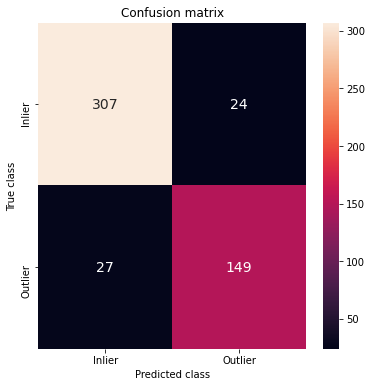

In [66]:
predictions = classify_by_error(test_MSEs, optimal_threshold_under)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'#### Best Threshold {optimal_threshold_under:.2f}, F1 Score {optimal_f1_under:.2f}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---

### 2. Denoising AutoEncoder

There is an aditional hyperparameter in the denoising autoencoder - noise rate. I have chosen its value 0.1 experimentally.

In [67]:
class DenoisingAutoEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], latent_size: int, noise_rate: float = 0.1):
        super(DenoisingAutoEncoder, self).__init__()
        self.noise_rate = noise_rate
        
        encode_layers = [nn.Linear(INPUT_SIZE, hidden_sizes[0]), nn.ReLU()]
        for i in range(len(hidden_sizes)-1):
            encode_layers += [nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.ReLU()]
        encode_layers += [nn.Linear(hidden_sizes[-1], latent_size)]
        self.encode = nn.Sequential(*encode_layers)
        
        decode_layers = [nn.Linear(latent_size, hidden_sizes[-1]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            decode_layers += [nn.Linear(hidden_sizes[-i], hidden_sizes[-i-1]), nn.ReLU()]
        decode_layers += [nn.Linear(hidden_sizes[0], INPUT_SIZE)]
        self.decode = nn.Sequential(*decode_layers)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            # randn_like returns tensor the same shape as x with random numbers
            # from a normal distribution with mean 0 and variance 1
            x = x + torch.randn_like(x) * self.noise_rate
        x = self.encode(x)
        x = self.decode(x)
        return x

In [68]:
best_model_params_dae, best_f1_dae = grid_search(ModelClass=DenoisingAutoEncoder,
                                                 model_name='denoising_autoencoder',
                                                 hidden_sizes_ls=[[16], [18], [18, 16]],
                                                 latent_sizes=[12, 14],
                                                 batch_sizes=[32, 64, 128], 
                                                 learning_rates=[1e-3, 1e-2], 
                                                 seeds=[0, 1, 2])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [14:32<00:00,  8.08s/it]


In [74]:
best_params_df_dae = pd.DataFrame([list(best_model_params_dae) + [best_f1_dae]], columns=['Hidden Sizes', 'Latent Size', 'Batch Size', 'Learning Rate', 'Seed', 'Threshold', 'F1 Score'])
display(Markdown('#### Best Parameters'))
display(best_params_df_dae.style.hide_index())

#### Best Parameters

Hidden Sizes,Latent Size,Batch Size,Learning Rate,Seed,Threshold,F1 Score
"[18, 16]",12,64,0.001000,0,4.600000,0.857955


Below, I run again the model with the best hyperparameters.

In [75]:
batch_size_dae = best_model_params_dae[2]
hidden_sizes_dae = best_model_params_dae[0]
latent_size_dae = best_model_params_dae[1]
learning_rate_dae = best_model_params_dae[3]
seed_dae = best_model_params_dae[4]

train_dataloader_dae = DataLoader(train_data, batch_size=batch_size_dae, worker_init_fn=seed_worker, shuffle=False)
val_dataloader_dae = DataLoader(val_data, batch_size=batch_size_dae, worker_init_fn=seed_worker, shuffle=False)

seed_all(seed_dae)
denoising_ae = DenoisingAutoEncoder(hidden_sizes=hidden_sizes_dae, latent_size=latent_size_dae)

optimizer_dae = torch.optim.Adam(denoising_ae.parameters(), lr=learning_rate_dae)
criterion_dae = nn.MSELoss()

In [76]:
train_model(model=denoising_ae, model_name='denoising_autoencoder', optimizer=optimizer_dae, criterion=criterion_dae,
            train_loader=train_dataloader_dae, val_loader=val_dataloader_dae, nr_of_epochs=200)

epoch 20; train loss: 0.2810297652202494; valid loss: 0.262992861866951
epoch 40; train loss: 0.21063781573491938; valid loss: 0.20053890645503997
epoch 60; train loss: 0.17799240175415487; valid loss: 0.167845618724823
epoch 80; train loss: 0.13241556505946553; valid loss: 0.1142901137471199
epoch 100; train loss: 0.10906535299385295; valid loss: 0.08841354250907899
epoch 120; train loss: 0.10111656828838236; valid loss: 0.08080225810408592
epoch 140; train loss: 0.09485143598388224; valid loss: 0.07402787953615189
epoch 160; train loss: 0.08643094800850924; valid loss: 0.06698484793305397
epoch 180; train loss: 0.08066995726788745; valid loss: 0.0638043113052845
epoch 200; train loss: 0.07677312765051336; valid loss: 0.06005171090364456


In [77]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,2.252344,0.0
std,10.951236,0.0
min,0.102357,0.0
25%,0.564487,0.0
50%,0.996288,0.0
75%,1.972276,0.0
max,197.650070,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,26.376417,1.0
std,55.906544,0.0
min,0.332025,1.0
25%,5.609365,1.0
50%,10.143871,1.0
75%,22.133160,1.0
max,426.904022,1.0


In [78]:
optimal_threshold_denoising, optimal_f1_denoising = try_threshold_grid(test_MSEs, y_test, 'denoising_autoencoder', start=0.1, stop=5.0, num_thresholds=50, verbose_lvl=1)

#### Model: denoising_autoencoder, trying 50 thresholds from [0.1, 5.0]

For more detail, call the function with `verbose_lvl=2`

#### Best Threshold 4.60, F1 Score 0.86

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.924471,0.857955,0.901381


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       331
           1       0.86      0.86      0.86       176

    accuracy                           0.90       507
   macro avg       0.89      0.89      0.89       507
weighted avg       0.90      0.90      0.90       507



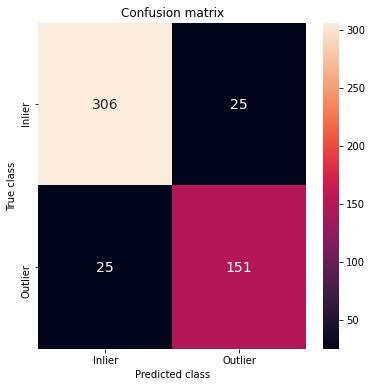

In [79]:
predictions = classify_by_error(test_MSEs, optimal_threshold_denoising)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'#### Best Threshold {optimal_threshold_denoising:.2f}, F1 Score {optimal_f1_denoising:.2f}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---

### 3. Variational AutoEncoder

#### Altered training, evaluation, and grid search functions

In [80]:
def train_one_epoch_VAE(model: nn.Module, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss, train_loader: DataLoader):
    '''
    Train one epoch of the model on training dataset batched by the train_loader.
    
    :param nn.Module model: model on which we perform one training epoch
    :param torch.optim.Optimizer optimizer: optimizer, e.g. ADAM or SGD
    :param nn.MSELoss criterion: loss function used for training
    :param DataLoader train_loader: data object for batching training set
    :returns: an average loss on the training dataset
    '''
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, _ = data
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

In [142]:
def train_model_VAE(model: nn.Module, model_name: str, optimizer: torch.optim.Optimizer, criterion: nn.MSELoss, 
                    train_loader: DataLoader, val_loader: DataLoader, nr_of_epochs: int = 100, verbose: bool = True):
    '''
    Train the specified model, and evaluate on validation data.
        
    :param nn.Module model: model being trained
    :param str model_name: model name, e.g. denoising_autoencoder
    :param torch.optim.Optimizer optimizer: optimizer, e.g. ADAM or SGD
    :param nn.MSELoss criterion: loss function used for training
    :param DataLoader train_loader: data object for batching the training set
    :param DataLoader val_loader: data object for batching the validation set
    :param int nr_of_epochs: number of training epochs
    :param bool verbose: determining whether training and validation losses should be printed
    '''
    best_loss = 10**12
    best_model, model_path, best_epoch = None, None, None

    for epoch in range(nr_of_epochs):
        model.train()
        train_loss = train_one_epoch_VAE(model, optimizer, criterion, train_loader)
        model.eval()

        # performance on validation set
        with torch.no_grad():
            valid_loss = 0.0
            for i, data in enumerate(val_loader):
                inputs, _ = data
                outputs = model(inputs.float())
                loss = ((outputs.float() - inputs.float()) ** 2).mean() + model.kl
                valid_loss += loss.item()
            valid_loss = valid_loss / len(val_loader)

            # logging at each Nth epoch
            if verbose and (epoch + 1) % 20 == 0:
                print(f'epoch {epoch + 1}; train loss: {train_loss}; valid loss: {valid_loss}')

            # remember model with the best validation loss
            if valid_loss < best_loss:
                best_loss = valid_loss
                best_model = model.state_dict()
                best_epoch = epoch + 1

    # save the overall best model
    if verbose:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        os.makedirs('models/', exist_ok=True)
        model_path = f'models/model_{model_name}_{timestamp}_epoch{best_epoch}'
        torch.save(best_model, model_path)

In [143]:
def eval_on_testset_VAE(model: nn.Module, testset: np.ndarray, test_labels: np.ndarray, verbose: bool = True) -> Tuple[pd.DataFrame, np.ndarray]:
    '''
    Evaluate testing data on the model, calculate reconstruction error, print statistics on inliers and outliers
        
    :param nn.Module model: model being evaluated
    :param np.ndarray testset: testing inputs
    :param np.ndarray test_labels: ground-truth labels
    :param bool verbose: determining whether training and validation losses should be printed
    :returns: dataframe with reconstruction errors and classes, reconstrution errors
    '''
    testset_tensor = torch.tensor(testset).float()
    reconstructed_test = model(testset_tensor)
    mse_test = torch.mean((reconstructed_test.detach() - testset_tensor) ** 2, axis=1) + model.kl.detach()
    error_df = pd.DataFrame({'Reconstruction Error': mse_test, 'class': y_test})
    
    if verbose:
        display(error_df[error_df['class'] == 0].describe())
        display(error_df[error_df['class'] == 1].describe())
    return error_df, mse_test

In [144]:
def train_eval_test_model_VAE(ModelClass: Type[nn.Module], hidden_sizes: List[int], latent_size: int, model_name: str,
                              batch_size: int, learning_rate: float, seed: int) -> Tuple[float, float]:
    '''
    Train and evaluate model with concrete hyperparameters, try threshold grid.
    
    :param Type[nn.Module] ModelClass: class of model to be trained
    :param List[int] hidden_sizes: list determining number of hidden layers and their sizes
    :param int latent_size: size of the latent space
    :param str model_name: name of the model architecture
    :param int batch_size: batch size for training and validation
    :param float learning_rate: learning rate for the optimizer
    :param int seed: random seed for PyTorch
    :returns: best MSE threshold, best F1 score
    '''
    train_loader = DataLoader(train_data, batch_size=batch_size, worker_init_fn=seed_worker, shuffle=False)
    val_loader = DataLoader(val_data, batch_size=batch_size, worker_init_fn=seed_worker, shuffle=False)
    
    seed_all(seed)
    model = ModelClass(hidden_sizes, latent_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    train_model_VAE(model=model, model_name=model_name, optimizer=optimizer, criterion=criterion,
                    train_loader=train_loader, val_loader=val_loader, nr_of_epochs=200, verbose=False)
    
    df, MSEs = eval_on_testset_VAE(model, X_test, y_test, verbose=False)
    threshold, f1 = try_threshold_grid(MSEs, y_test, model_name, start=0.1, stop=5.0, num_thresholds=50, verbose_lvl=0)
    return threshold, f1

In [145]:
def grid_search_VAE(ModelClass: Type[nn.Module], model_name: str, hidden_sizes_ls: List[List[int]], latent_sizes: List[int],
                    batch_sizes: List[int], learning_rates: List[float], seeds: List[int]):
    '''
    Try out grid of hyperparameters constructed as a cartesian product of the given values, 
    return the best parameters according to the model's F1 score.
    
    :param Type[nn.Module] ModelClass: class of model to be trained
    :param str model_name: name of the model architecture
    :param List[List[int]] hidden_sizes_ls: list of lists determining number of hidden layers and their sizes
    :param List[int] latent_sizes: sizes of the latent space
    :param List[int] batch_sizes: batch sizes for training and validation
    :param List[float] learning_rates: learning rates for the optimizer
    :param List[int] seeds: random seeds for PyTorch
    :returns: best hyperparameters, best F1 score
    '''
    best_f1 = 0.0
    best_model_params = None
    
    cartes_product = list(itertools.product(hidden_sizes_ls, latent_sizes, batch_sizes, learning_rates, seeds))
    for hidden_sizes, latent_size, batch_size, learning_rate, seed in tqdm(cartes_product):
        threshold, f1 = train_eval_test_model_VAE(ModelClass, hidden_sizes, latent_size, model_name, batch_size, learning_rate, seed)
        if f1 > best_f1:
            best_f1 = f1
            best_model_params = hidden_sizes, latent_size, batch_size, learning_rate, seed, threshold
    return best_model_params, best_f1

#### Experiments

In [132]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_sizes: List[int], latent_size: int):
        super(VariationalAutoEncoder, self).__init__()
        
        self.encLayers = [nn.Linear(INPUT_SIZE, hidden_sizes[0]), nn.ReLU()]
        for i in range(len(hidden_sizes)-1):
            self.encLayers += [nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.ReLU()]
        self.encLinMu = nn.Linear(hidden_sizes[-1], latent_size)
        self.encLinSigma = nn.Linear(hidden_sizes[-1], latent_size)
        self.normal = torch.distributions.Normal(0, 1)
        self.kl = 0

        self.decLayers = [nn.Linear(latent_size, hidden_sizes[-1]), nn.ReLU()]
        for i in range(1, len(hidden_sizes)):
            self.decLayers += [nn.Linear(hidden_sizes[-i], hidden_sizes[-i-1]), nn.ReLU()]
        self.decLayers += [nn.Linear(hidden_sizes[0], INPUT_SIZE)]        
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self.encLayers:
            x = layer(x)
        mu = self.encLinMu(x)
        sigma = torch.exp(self.encLinSigma(x))
        x = mu + sigma * self.normal.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).mean()

        for layer in self.decLayers:
            x = layer(x)
        return x

In [133]:
best_model_params_vae, best_f1_vae = grid_search_VAE(ModelClass=VariationalAutoEncoder,
                                                     model_name='variational_autoencoder',
                                                     hidden_sizes_ls=[[16], [18], [18, 16]],
                                                     latent_sizes=[12, 14],
                                                     batch_sizes=[32, 64, 128], 
                                                     learning_rates=[1e-3, 1e-2], 
                                                     seeds=[0, 1, 2])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [14:19<00:00,  7.96s/it]


In [134]:
best_params_df_vae = pd.DataFrame([list(best_model_params_vae) + [best_f1_vae]], columns=['Hidden Sizes', 'Latent Size', 'Batch Size', 'Learning Rate', 'Seed', 'Threshold', 'F1 Score'])
display(Markdown('#### Best Parameters'))
display(best_params_df_vae.style.hide_index())

#### Best Parameters

Hidden Sizes,Latent Size,Batch Size,Learning Rate,Seed,Threshold,F1 Score
[18],12,32,0.001000,2,1.700000,0.861789


Below, I run again the model with the best hyperparameters.

In [146]:
batch_size_vae = best_model_params_vae[2]
hidden_sizes_vae = best_model_params_vae[0]
latent_size_vae = best_model_params_vae[1]
learning_rate_vae = best_model_params_vae[3]
seed_vae = best_model_params_vae[4]

train_dataloader_vae = DataLoader(train_data, batch_size=batch_size_vae, worker_init_fn=seed_worker, shuffle=False)
val_dataloader_vae = DataLoader(val_data, batch_size=batch_size_vae, worker_init_fn=seed_worker, shuffle=False)

seed_all(seed_vae)
variational_ae = VariationalAutoEncoder(hidden_sizes=hidden_sizes_vae, latent_size=latent_size_vae)

optimizer_vae = torch.optim.Adam(variational_ae.parameters(), lr=learning_rate_vae)
criterion_vae = nn.MSELoss()

In [147]:
train_model_VAE(model=variational_ae, model_name='variational_autoencoder', optimizer=optimizer_vae, criterion=criterion_vae,
                train_loader=train_dataloader_vae, val_loader=val_dataloader_vae, nr_of_epochs=200)

epoch 20; train loss: 1.1857427814427544; valid loss: 1.1831059455871582
epoch 40; train loss: 1.1772580742835999; valid loss: 1.1772691673702664
epoch 60; train loss: 1.1774289222324597; valid loss: 1.1755044195387099
epoch 80; train loss: 1.1802274269216202; valid loss: 1.175316572189331
epoch 100; train loss: 1.176976584336337; valid loss: 1.1717075374391344
epoch 120; train loss: 1.176732739981483; valid loss: 1.169948485162523
epoch 140; train loss: 1.1805214461158304; valid loss: 1.169108231862386
epoch 160; train loss: 1.1757236088023466; valid loss: 1.1730745236078899
epoch 180; train loss: 1.178123744095073; valid loss: 1.1774977445602417
epoch 200; train loss: 1.1740533078418058; valid loss: 1.1730737156338162


In [148]:
test_df, test_MSEs = eval_on_testset(denoising_ae, X_test, y_test)

,Reconstruction Error,class
count,331.000000,331.0
mean,2.252344,0.0
std,10.951236,0.0
min,0.102357,0.0
25%,0.564487,0.0
50%,0.996288,0.0
75%,1.972276,0.0
max,197.650070,0.0


,Reconstruction Error,class
count,176.000000,176.0
mean,26.376417,1.0
std,55.906544,0.0
min,0.332025,1.0
25%,5.609365,1.0
50%,10.143871,1.0
75%,22.133160,1.0
max,426.904022,1.0


In [149]:
optimal_threshold_vae, optimal_f1_vae = try_threshold_grid(test_MSEs, y_test, 'variational_autoencoder', start=0.1, stop=5.0, num_thresholds=50, verbose_lvl=1)

#### Model: variational_autoencoder, trying 50 thresholds from [0.1, 5.0]

For more detail, call the function with `verbose_lvl=2`

#### Best Threshold 4.60, F1 Score 0.86

Inliers Accuracy,Outliers Accuracy,Overall Accuracy
0.924471,0.857955,0.901381


##### Classification Report

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       331
           1       0.86      0.86      0.86       176

    accuracy                           0.90       507
   macro avg       0.89      0.89      0.89       507
weighted avg       0.90      0.90      0.90       507



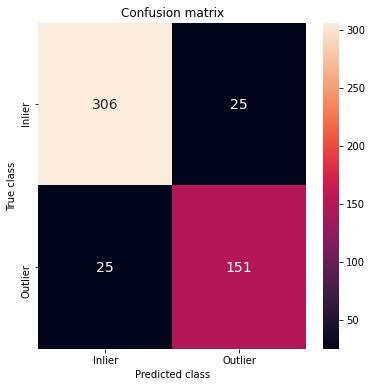

In [150]:
predictions = classify_by_error(test_MSEs, optimal_threshold_vae)
matrix = confusion_matrix(y_test, predictions)
class_accuracies = matrix.diagonal()/matrix.sum(axis=1)
acc_df = pd.DataFrame({
    'Inliers Accuracy': [class_accuracies[0]], 
    'Outliers Accuracy': [class_accuracies[1]], 
    'Overall Accuracy': [accuracy_score(y_test, predictions)]
})

display(Markdown(f'#### Best Threshold {optimal_threshold_vae:.2f}, F1 Score {optimal_f1_vae:.2f}'))
display(acc_df.style.hide_index())
display(Markdown(f'##### Classification Report'))
print(classification_report(y_test, predictions))
plot_confusion_matrix(matrix)

---
---

## Final Remarks

I have compared three different autoencoder architectures for outlier detection:
1. undercomplete autoencoder
2. denoising autoencoder
3. variational autoencoder

For each of them, I tuned the following hyperparameters in a grid search:
- Batch size
- Learning rate
- Hidden layer count and dimension
- Latent space dimension
- Thresholds on reconstruction errors from interval.

I have chosen the best classifier based on the F1-score, where negative class is composed of inliers and positive class is composed of outliers.

Below, you can find the best hyper-parameters of the architectures. As for the layers, only encoder architecture is shown, since decoder contains almost the same layers, just reversed.

In [151]:
result_df = pd.DataFrame({'Architecture': ['Undercomplete Autoencoder', 'Denoising Autoencoder', 'Variational Autoencoder'],
                          'F1 Score': [optimal_f1_under, optimal_f1_denoising, optimal_f1_vae],
                          'Learning Rate': [learning_rate_uae, learning_rate_dae, learning_rate_vae],
                          'Batch Size': [batch_size_uae, batch_size_dae, batch_size_vae], 
                          'Hidden Layers': [hidden_sizes_uae, hidden_sizes_dae, hidden_sizes_vae],
                          'Latent Space Size': [latent_size_uae, latent_size_dae, latent_size_vae],
                          'Seed': [seed_uae, seed_dae, seed_vae],
                          'MSE Threshold': [optimal_threshold_under, optimal_threshold_denoising, optimal_threshold_vae],
                         })
result_df = result_df.set_index('Architecture')
display(result_df)

,F1 Score,Learning Rate,Batch Size,Hidden Layers,Latent Space Size,Seed,MSE Threshold
Architecture,,,,,,,
Undercomplete Autoencoder,0.853868,0.010,32,[18],14,1,0.6
Denoising Autoencoder,0.857955,0.001,64,"[18, 16]",12,0,4.6
Variational Autoencoder,0.857955,0.001,32,[18],12,2,4.6
